[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/matinm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loading raw price data...
Loading tweet data...

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 0.0650 - val_loss: 0.0066 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.0066 - val_loss: 0.0045 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.0047 - val_loss: 0.0034 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0048 - val_loss: 0.0100 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0061 - val_loss: 0.0042 - learning_rate: 0.00

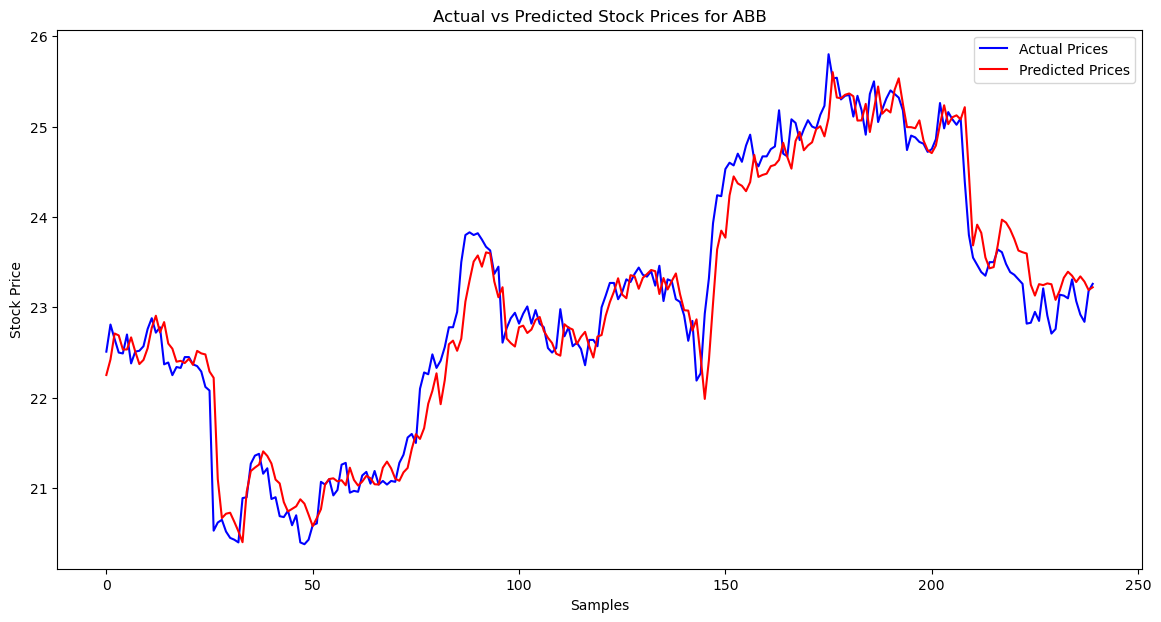

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted stock price for the next day: 23.40


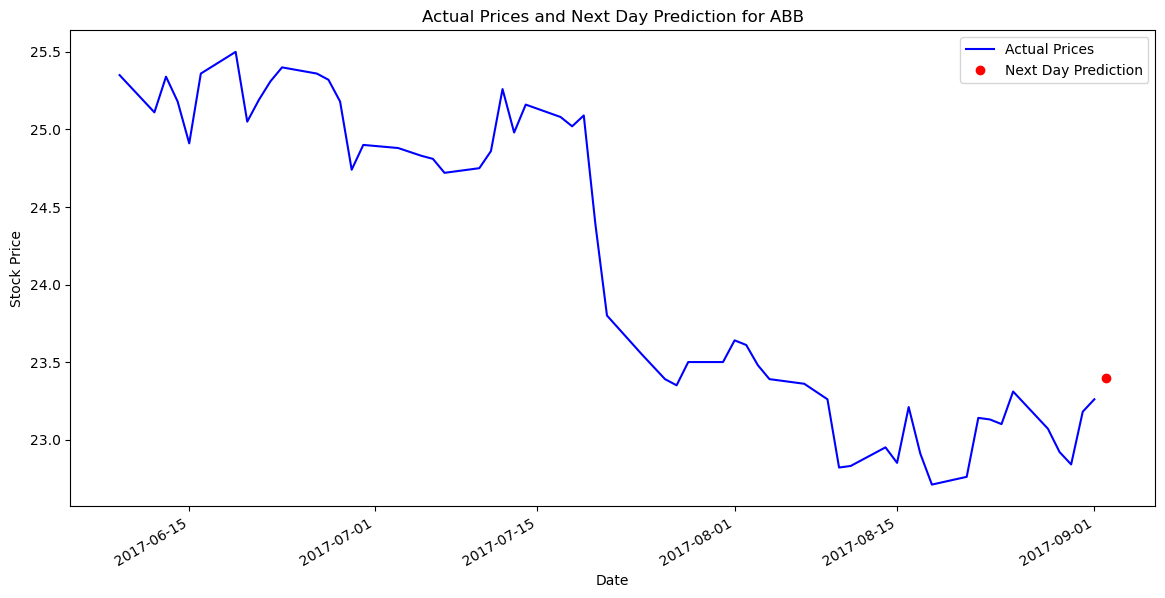

In [3]:
import os
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Ensure NLTK Sentiment Analyzer is downloaded
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# Function to parse tweet files
def parse_tweet_file(file_path):
    tweets = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read().strip()
        try:
            tweets_data = json.loads(content)
            if isinstance(tweets_data, list):
                tweets.extend(tweets_data)
            else:
                tweets.append(tweets_data)
        except json.JSONDecodeError:
            lines = content.splitlines()
            for line in lines:
                if line.strip():
                    try:
                        tweet = json.loads(line)
                        tweets.append(tweet)
                    except json.JSONDecodeError:
                        continue
    return tweets

# Load stock price data for a specific stock from raw CSV
def load_price_data_raw(path, stock_symbol):
    print("Loading raw price data...")
    stock_file = f"{stock_symbol}.csv"
    stock_path = os.path.join(path, stock_file)
    if os.path.exists(stock_path):
        df = pd.read_csv(
            stock_path,
            parse_dates=['Date']
        )
        df['Stock'] = stock_symbol
        df.sort_values(by='Date', inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df
    else:
        raise FileNotFoundError(f"Raw price data for stock {stock_symbol} not found at {stock_path}.")

# Load tweet data for a specific stock
def load_tweet_data(path, stock_symbol):
    print("Loading tweet data...")
    stock_path = os.path.join(path, stock_symbol)
    if os.path.isdir(stock_path):
        all_tweet_data = []
        for tweet_file in os.listdir(stock_path):
            if tweet_file.startswith('.'):
                continue  # Skip hidden files
            tweet_path = os.path.join(stock_path, tweet_file)
            tweet_data = parse_tweet_file(tweet_path)
            if tweet_data:
                for tweet in tweet_data:
                    text = tweet.get('text', '')
                    # Ensure text is a string
                    if not isinstance(text, str):
                        text = str(text)
                    # Calculate sentiment scores
                    sentiment_scores = sid.polarity_scores(text)
                    all_tweet_data.append({
                        'Stock': stock_symbol,
                        'Date': tweet_file.split('.')[0],  
                        'Text': text,
                        'Sentiment': sentiment_scores['compound']
                    })
        tweets_df = pd.DataFrame(all_tweet_data)
        tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])
        return tweets_df
    else:
        
        print(f"Tweet data for stock {stock_symbol} not found at {stock_path}. Proceeding without tweets.")
        tweets_df = pd.DataFrame(columns=['Stock', 'Date', 'Text', 'Sentiment'])
        return tweets_df

# Aggregate tweets
def aggregate_tweets(tweets_df):
    if tweets_df.empty:
        # Return empty DataFrame with necessary columns
        daily_sentiment = pd.DataFrame(columns=['Stock', 'Date', 'Tweet_Count', 'Average_Sentiment'])
    else:
        daily_sentiment = tweets_df.groupby(['Stock', 'Date']).agg(
            Tweet_Count=('Text', 'count'),
            Average_Sentiment=('Sentiment', 'mean')
        ).reset_index()
    return daily_sentiment

# Merge stock and tweet data
def merge_data(price_data, sentiment_data):
    combined_data = pd.merge(price_data, sentiment_data, on=['Stock', 'Date'], how='left')
    combined_data['Tweet_Count'] = combined_data['Tweet_Count'].fillna(0)
    combined_data['Average_Sentiment'] = combined_data['Average_Sentiment'].fillna(0)
    return combined_data

# Enhanced Feature Engineering
def add_features(data):
    # Calculate moving averages and other technical indicators
    data['7_day_MA'] = data['Close'].rolling(window=7).mean()
    data['14_day_MA'] = data['Close'].rolling(window=14).mean()
    data['21_day_MA'] = data['Close'].rolling(window=21).mean()
    data['7_day_STD'] = data['Close'].rolling(window=7).std()
    data['Bollinger_Upper'] = data['7_day_MA'] + (data['7_day_STD'] * 2)
    data['Bollinger_Lower'] = data['7_day_MA'] - (data['7_day_STD'] * 2)
    data['Momentum'] = data['Close'] - data['Close'].shift(7)

    # Fill missing values
    data.fillna(method='bfill', inplace=True)
    data.fillna(0, inplace=True)
    return data

# Apply Exponential Moving Average to smooth the data
def smooth_data(data, column='Close', alpha=0.1):
    ema = data[column].ewm(alpha=alpha).mean()
    data[f'{column}_EMA'] = ema
    return data

# Create sequences for time series prediction
def create_sequences(data, sequence_length, features, target_feature):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i + sequence_length][features].values)
        y.append(data.iloc[i + sequence_length][target_feature])
    return np.array(X), np.array(y)

# Build LSTM model
def build_model(input_shape, units1=200, units2=200, units3=150, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units3))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 20
    if epoch % decay_step == 0 and epoch != 0:
        return lr * decay_rate
    return lr


def main():
    stock_symbol = 'ABB'  # Specify the stock to predict

    price_data_path = 'stocknet-dataset/price/raw'
    tweet_data_path = 'stocknet-dataset/tweet/preprocessed'

    # Load and preprocess data for the specific stock
    price_data = load_price_data_raw(price_data_path, stock_symbol)
    tweet_data = load_tweet_data(tweet_data_path, stock_symbol)

    # Aggregate tweets
    daily_sentiment = aggregate_tweets(tweet_data)
    combined_data = merge_data(price_data, daily_sentiment)

    # Ensure 'Date' column is of datetime type
    combined_data['Date'] = pd.to_datetime(combined_data['Date'])

    # Apply feature engineering
    combined_data = add_features(combined_data)

    # Apply Exponential Moving Average to smooth the 'Close' price
    combined_data = smooth_data(combined_data, column='Close', alpha=0.1)

    # Define features and target
    features = ['Open', 'High', 'Low', 'Volume',
                '7_day_MA', '14_day_MA', '21_day_MA',
                'Bollinger_Upper', 'Bollinger_Lower', 'Momentum',
                'Tweet_Count', 'Average_Sentiment', 'Close_EMA']
    target_feature = 'Close'  # Use the actual 'Close' price as the target

    # Ensure data is clean
    combined_data.dropna(inplace=True)
    combined_data.reset_index(drop=True, inplace=True)

    # Normalize data
    scaled_columns = features + [target_feature]
    feature_scaler = MinMaxScaler()
    combined_data[scaled_columns] = feature_scaler.fit_transform(combined_data[scaled_columns])

    # Prepare sequences
    sequence_length = 60  # Adjusted sequence length
    X, y = create_sequences(combined_data, sequence_length, features, target_feature)

    # Check if we have enough samples
    if len(X) == 0:
        print("Not enough data to create sequences. Please check the sequence length and data size.")
        return

    # Split data into training and testing sets
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Build and train model
    model = build_model(X_train.shape[1:], units1=200, units2=200, units3=150)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_schedule],
        verbose=1
    )

    # Evaluate model
    y_pred = model.predict(X_test)

    # Inverse transform predictions and actual values
    y_test_inv = feature_scaler.inverse_transform(
        np.concatenate((np.zeros((y_test.shape[0], len(scaled_columns) - 1)), y_test.reshape(-1, 1)), axis=1)
    )[:, -1]
    y_pred_inv = feature_scaler.inverse_transform(
        np.concatenate((np.zeros((y_pred.shape[0], len(scaled_columns) - 1)), y_pred), axis=1)
    )[:, -1]

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Plot predictions
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_inv, label='Actual Prices', color='blue')
    plt.plot(y_pred_inv, label='Predicted Prices', color='red')
    plt.title(f'Actual vs Predicted Stock Prices for {stock_symbol}')
    plt.xlabel('Samples')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Predict the next day's stock price
    last_sequence = combined_data[features].values[-sequence_length:]
    last_sequence_scaled = last_sequence.reshape((1, sequence_length, len(features)))
    next_day_prediction = model.predict(last_sequence_scaled)

    # Inverse transform the prediction
    next_day_prediction_inv = feature_scaler.inverse_transform(
        np.concatenate((np.zeros((1, len(scaled_columns) - 1)), next_day_prediction), axis=1)
    )[:, -1]

    print(f"Predicted stock price for the next day: {next_day_prediction_inv[0]:.2f}")

    # Prepare data for plotting
    last_actual_prices = feature_scaler.inverse_transform(
        np.concatenate((np.zeros((sequence_length, len(scaled_columns) - 1)),
                        combined_data[target_feature].values[-sequence_length:].reshape(-1, 1)), axis=1)
    )[:, -1]
    last_actual_dates = combined_data['Date'].iloc[-sequence_length:].tolist()

    next_day_date = combined_data['Date'].iloc[-1] + pd.Timedelta(days=1)
    all_dates = last_actual_dates + [next_day_date]
    all_prices = np.append(last_actual_prices, next_day_prediction_inv[0])

    # Plot the prediction for the next day
    plt.figure(figsize=(14, 7))
    plt.plot(all_dates[:-1], all_prices[:-1], label='Actual Prices', color='blue')
    plt.plot(all_dates[-1], all_prices[-1], 'o', label='Next Day Prediction', color='red')
    plt.title(f'Actual Prices and Next Day Prediction for {stock_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.gcf().autofmt_xdate()  
    plt.show()

if __name__ == "__main__":
    main()
